In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pickle
import pandas as pd

In [2]:
higgs_file = open ("higgs_100000_pt_250_500.pkl", 'rb')
qcd_file = open ("qcd_100000_pt_250_500.pkl", 'rb')

# QCD is background, Higgs is signal
qcd = pickle.load(qcd_file)
higgs = pickle.load(higgs_file)


print("pt = Transverse Momentum")
print("eta = Pseudo Rapidity")
print("phi = Azimuthal Angle")
print("mass = Mass")
print("ee2 = Energy Correlation Function 2")
print("ee3 = Energy Correlation Function 3")
print("d2 = Energy Correlation Function")
print("angularity = Jet broadness to thrust ratio")
print("t1 = subjettiness of degree 1")
print("t2 = subjettiness of degree 2") 
print("t3 = subjettiness of degree 3")
print("t21 = ratio of t2/t1")
print("t32 = ratio of t3/t2")
print("KtDeltaR = Delta R of two subjets within large-R jet")

pt = Transverse Momentum
eta = Pseudo Rapidity
phi = Azimuthal Angle
mass = Mass
ee2 = Energy Correlation Function 2
ee3 = Energy Correlation Function 3
d2 = Energy Correlation Function
angularity = Jet broadness to thrust ratio
t1 = subjettiness of degree 1
t2 = subjettiness of degree 2
t3 = subjettiness of degree 3
t21 = ratio of t2/t1
t32 = ratio of t3/t2
KtDeltaR = Delta R of two subjets within large-R jet


Above is a translation of the name of the data inside the dataset to what it represents. From this point on these may be used interchangeably in descriptions and labels. Anytime "QCD" is used (as in the name of the dataset), it refers to the simulation data. Anytime "Higgs" is used it refers to the pseudo-experiment data.

In this lab we're looking for what features provide the most discrimination between background and the Higgs boson (pseudo-experiment analysis in Lab 8 file). To do this, we need to do multiple things. The first is normalize the QCD and Higgs simulation data to their expected number of events (20,000 for QCD and 100 for Higgs). For normalizing a histogram we just multiple the number of expected events by the inverse of the length of the dataset. A stacked normalized histogram of the simulations is shown below. Mass is used in this histogram because it is the main fewature variable in the search for the Higgs Boson (particles have different energies/masses upon creation).

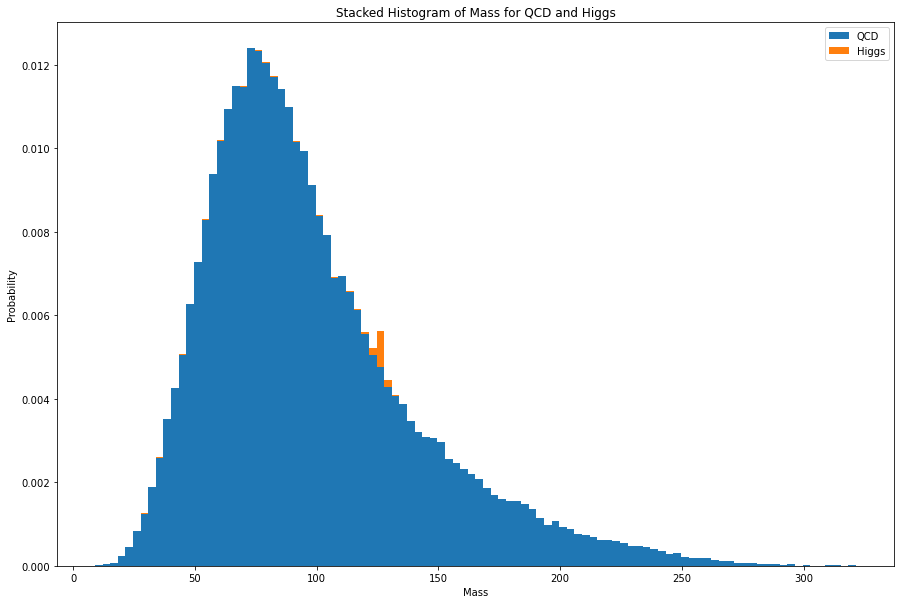

In [3]:
n_higgs = 100 / 100000
n_qcd = 20000 / 100000

fig, ax = plt.subplots(1, 1, figsize = (15, 10))

qcd_weight = np.array([n_qcd] * len(qcd['mass']))
higgs_weight = np.array([n_higgs] * len(higgs['mass']))

ax.hist([qcd['mass'], higgs['mass']], bins = 100, density = True, stacked = True, weights = [qcd_weight, higgs_weight])

ax.legend(["QCD", "Higgs"])
ax.set_title("Stacked Histogram of Mass for QCD and Higgs")
ax.set_xlabel("Mass")
ax.set_ylabel("Probability")

plt.show()

Using just this stacked histogram we can get two things- an expected significance and an approximated significance. The expected significance is the significance we would see given the full range of values without any cuts. This is calculated using Poisson statistics- particle events follow Poisson distributions in their creation, so we use the expected number of QCD events as the mean of the Poisson, and the expected number of Higgs events plus QCD events as the point we are looking at in the cdf function, then use the PPF on this. The approximation is done as $ N_{Higgs} / \sqrt(N_{QCD}) $.

In [4]:
n_higgs = 100
n_qcd = 20000

exp_prob = stats.poisson.cdf(n_higgs + n_qcd, n_qcd, loc = 0)
exp_sig = stats.norm.ppf(exp_prob)

approx_sig = n_higgs / np.sqrt(n_qcd)

print("The expected significance of the Higgs Boson is " + str(exp_sig) + ". The approximation is " + str(approx_sig) + ".")

The expected significance of the Higgs Boson is 0.7112259282313185. The approximation is 0.7071067811865475.


# Cuts

Below are stacked histograms for all features for reference.

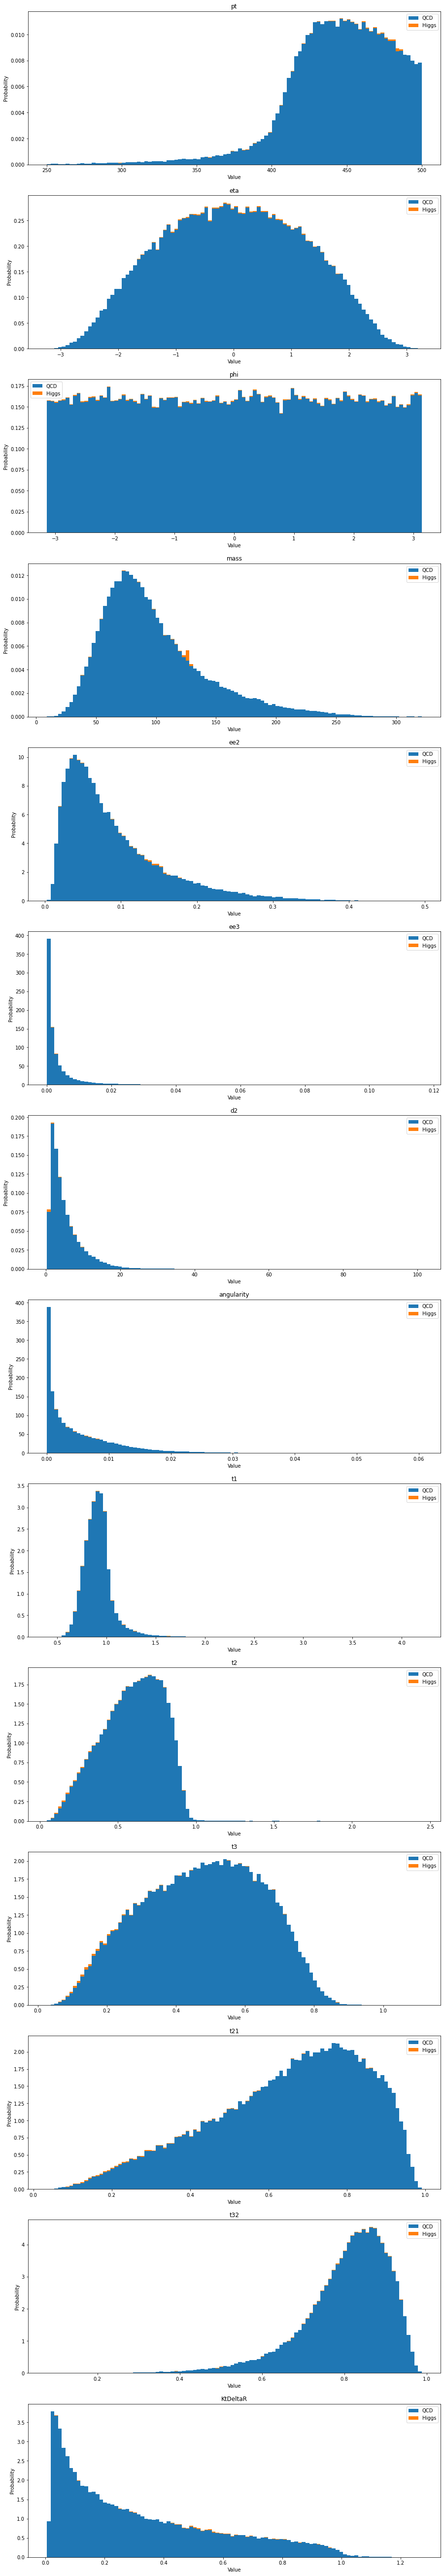

In [5]:
n_higgs = 100 / 100000
n_qcd = 20000 / 100000

fig, ax = plt.subplots(14, 1, figsize = (15, 95))

j = 0
for key in qcd:
    n_higgs = 100 / 100000
    n_qcd = 20000 / 100000

    qcd_weight = np.array([n_qcd] * len(qcd[key]))
    higgs_weight = np.array([n_higgs] * len(higgs[key]))

    ax[j].hist([qcd[key], higgs[key]], bins = 100, density = True, stacked = True, weights = [qcd_weight, higgs_weight])
#         ax[j].hist(qcd[key], bins = 100, density = True)
#         ax[j].hist(higgs[key], bins = 100, density = True)
    ax[j].set_title(key)
    ax[j].legend(["QCD", "Higgs"])
    ax[j].set_xlabel("Value")
    ax[j].set_ylabel("Probability")
    
    j = j + 1

plt.show()

Next is to determine cuts. This is attempted in multiple ways here, then the method with the highest significance was used (all methods used for all features initially).The first method was dividing the feature in to histograms of varying bin size (from 1 bin to 100 bins), then seeing which bin had the highest significance. Significance here was calculated using Poisson statistics as above, but with $ N_{Higgs} $ and $ N_{QCD} $ being the (scaled) number of events in the bin.

In [6]:
n_higgs = 100 / 100000
n_qcd = 20000 / 100000

fig, ax = plt.subplots(14, 1, figsize = (15, 95))
plt.close()
fig2, ax2 = plt.subplots(1,1)
plt.close()

j = 0
for key in qcd:
    print(key + " with equally sized bins:")
    n_higgs = 100 / 100000
    n_qcd = 20000 / 100000
    qcd_weight = np.array([n_qcd] * len(qcd[key]))
    higgs_weight = np.array([n_higgs] * len(higgs[key]))

#     For graphing
    ax[j].hist([qcd[key], higgs[key]], bins = 100, density = False, stacked = True, weights = [qcd_weight, higgs_weight])
    ax[j].set_title(key)
    ax[j].legend(["QCD", "Higgs"])

    # For cuts
    max_array = []
    for bin_num in range(1, 101, 1):

        lower_val = qcd[key].min()
        upper_val = qcd[key].max()

        hist_qcd = ax2.hist(qcd[key], bins = bin_num, density = False, weights = [qcd_weight], range = (lower_val, upper_val))
        hist_higgs = ax2.hist(higgs[key], bins = bin_num, density = False, weights = [higgs_weight], range = (lower_val, upper_val))

        cut_sigs = []
        for i in range(bin_num):
            n_qcd = hist_qcd[0][i]
            n_higgs = hist_higgs[0][i]
            sig = stats.norm.ppf(stats.poisson.cdf(n_higgs + n_qcd, n_qcd, loc = 0))
            if sig != float('inf'):
                cut_sigs.append(sig)
            elif sig == float('inf'):
                cut_sigs.append(0)

        index_max = cut_sigs.index(max(cut_sigs, key = abs))
        max_array.append([bin_num, cut_sigs[index_max], index_max])

    max_sig = max_array[0][1]
    ind = 0
    for k in range(len(max_array)):
        if abs(max_array[k][1]) > abs(max_sig):
            max_sig = max_array[k][1]
            ind = k

    bottom_val = lower_val + max_array[ind][2] * ((upper_val - lower_val) / max_array[ind][0])
    top_val = bottom_val + ((upper_val - lower_val) / max_array[ind][0])
    if max_array[ind][0] == 1:
        print("For " + key + " there is no optimal cut. Expected significance over full range is " + str(max_array[ind][1]) + ".")
    else:    
        print("For " + key + ", the optimal cut is between " + str(bottom_val) + " and " + str(top_val) + " with an expected significance of " + str(max_array[ind][1]) + ".")
    print("[Number of bins, Significance, Bin number] = " + str(max_array[ind]))
    print(" --------------- ")

    j = j + 1

pt with equally sized bins:
For pt, the optimal cut is between 472.2359803377992 and 486.11791027426705 with an expected significance of 0.7560595953261303.
[Number of bins, Significance, Bin number] = [18, 0.7560595953261303, 16]
 --------------- 
eta with equally sized bins:
For eta, the optimal cut is between -1.0959618043336454 and 1.0483205468583972 with an expected significance of 0.7116877761437944.
[Number of bins, Significance, Bin number] = [3, 0.7116877761437944, 1]
 --------------- 
phi with equally sized bins:
For phi there is no optimal cut. Expected significance over full range is 0.7041666185570017.
[Number of bins, Significance, Bin number] = [1, 0.7041666185570017, 0]
 --------------- 
mass with equally sized bins:
For mass, the optimal cut is between 124.27893475850834 and 127.56425239921401 with an expected significance of 3.096923101184199.
[Number of bins, Significance, Bin number] = [95, 3.096923101184199, 35]
 --------------- 
ee2 with equally sized bins:
For ee

The second method was essentially done by taking a bin that started at the minimum (far left) of the histogram, and gradually increasing the size of this bin until it was the full histogram size. The significance was done using the significance in this far left bin each time. In reality it was actually done slightly differently- by dividing the histogram into 100 bins and taking the far left bin, then the far left two bins, etc. until all 100 bins were included.

In [7]:
fig, ax = plt.subplots(1, 1)

for key in qcd:
    print(key + " from bottom up:")
    
    n_higgs = 100 / 100000
    n_qcd = 20000 / 100000

    lower_val = qcd[key].min()
    upper_val = qcd[key].max()

    hist_qcd = ax.hist(qcd[key], bins = 100, density = False, weights = [qcd_weight], range = (lower_val, upper_val))
    hist_higgs = ax.hist(higgs[key], bins = 100, density = False, weights = [higgs_weight], range = (lower_val, upper_val))

    cut_sigs = []
    for i in range(100):
        n_qcd = np.sum(hist_qcd[0][0:i])
        n_higgs = np.sum(hist_higgs[0][0:i])
        sig = stats.norm.ppf(stats.poisson.cdf(n_higgs + n_qcd, n_qcd, loc = 0))
        if sig != float('inf'):
            cut_sigs.append(sig)

    index_max = cut_sigs.index(max(cut_sigs))

    print("Optimal cut is between " + str(lower_val) + " and " + str(((index_max + 1) * ((upper_val - lower_val) / 100)) + lower_val) + " with an expected significance of " + str(cut_sigs[index_max]))
    print(" --------------- ")
    
plt.close()

pt from bottom up:
Optimal cut is between 250.12510135431387 and 487.50610326791383 with an expected significance of 0.7472453236965926
 --------------- 
eta from bottom up:
Optimal cut is between -3.240244155525688 and 1.4557341935848847 with an expected significance of 0.7253808167305906
 --------------- 
phi from bottom up:
Optimal cut is between -3.1415368791145792 and 3.015909878654331 with an expected significance of 0.7016350358888966
 --------------- 
mass from bottom up:
Optimal cut is between 9.292817333809852 and 134.13488768062538 with an expected significance of 0.7818334989124891
 --------------- 
ee2 from bottom up:
Optimal cut is between 0.0023917195413247693 and 0.22449002575228885 with an expected significance of 0.7227321293227505
 --------------- 
ee3 from bottom up:
Optimal cut is between 6.406593797149574e-07 and 0.006977034918989738 with an expected significance of 0.7394035709859783
 --------------- 
d2 from bottom up:
Optimal cut is between 0.2813436928759825 a

The third method is a repeat of the last method, but from the largest (far right) value.

In [8]:
fig, ax = plt.subplots(1, 1)

for key in qcd:
    print(key + " from top down:")
    
    n_higgs = 100
    n_qcd = 20000

    lower_val = qcd[key].min()
    upper_val = qcd[key].max()
    
    hist_qcd = ax.hist(qcd[key], bins = 100, density = False, weights = [qcd_weight], range = (lower_val, upper_val))
    hist_higgs = ax.hist(higgs[key], bins = 100, density = False, weights = [higgs_weight], range = (lower_val, upper_val))

    cut_sigs = []
    for i in range(100):
        n_qcd = np.sum(hist_qcd[0][100-i:i])
        n_higgs = np.sum(hist_higgs[0][100-i:i])
        sig = stats.norm.ppf(stats.poisson.cdf(n_higgs + n_qcd, n_qcd, loc = 0))
        if sig != float('inf'):
            cut_sigs.append(sig)
        elif sig == float('inf'):
            cut_sigs.append(0)

    index_max = cut_sigs.index(max(cut_sigs))

    print("Optimal cut is between " + str(((index_max + 1) * ((upper_val - lower_val) / 100) + lower_val)) + " and " + str(upper_val) + " with an expected significance of " + str(cut_sigs[index_max]))
    print(" --------------- ")
    
plt.close()

pt from top down:
Optimal cut is between 490.004850656478 and 499.9998402107349 with an expected significance of 0.7430338076891584
 --------------- 
eta from top down:
Optimal cut is between 1.5200626641206458 and 3.192602898050439 with an expected significance of 0.7458517655389812
 --------------- 
phi from top down:
Optimal cut is between 3.1415720573843084 and 3.1415720573843084 with an expected significance of 0.7014205128238309
 --------------- 
mass from top down:
Optimal cut is between 215.28223340605547 and 321.39799320084865 with an expected significance of 1.1821674315848854
 --------------- 
ee2 from top down:
Optimal cut is between 0.3972331528052609 and 0.49594351112124496 with an expected significance of 1.000681706348732
 --------------- 
ee3 from top down:
Optimal cut is between 0.11627387831954676 and 0.11627387831954676 with an expected significance of 0.8259415527258129
 --------------- 
d2 from top down:
Optimal cut is between 54.75396118453969 and 101.15656127003

The last method was done using symmetrical bins around the maximum of the Higgs graph for each feature, gradually increasing the size of the bins. Significance was done the same as always within these bins.

In [9]:
fig, ax = plt.subplots(1, 1)

for key in qcd:
    print(key + " around maximum of Higgs graph:")
    
    n_higgs = 100 / 100000
    n_qcd = 20000 / 100000
    
    lower_val = higgs[key].min()
    upper_val = higgs[key].max()

    hist_higgs = ax.hist(higgs[key], bins = 100, density = False, weights = [higgs_weight], range = (lower_val, upper_val))
    

    
    higgs_ind = np.argmax(hist_higgs[0])
    max_higgs = hist_higgs[1][higgs_ind]
    
#     print(higgs_ind, hist_higgs[1][higgs_ind])
    
    div_size = (upper_val - lower_val) / 40
#     print(upper_val, lower_val, div_size, max_higgs)
    
    higgs_sorted = np.sort(higgs[key])
    qcd_sorted = np.sort(qcd[key])
    
    max_ind = 0
    for i in range(len(higgs_sorted)):
        if higgs_sorted[i] >= max_higgs:
            max_ind = i
            break
    
    cut_sigs = []
    
    for j in range(1, 21, 1):
        higgs_count = 0
        qcd_count = 0
        
        for i in range(len(higgs_sorted)):
            if(higgs_sorted[i] >= (max_higgs - (j * div_size)) and higgs_sorted[i] <= (max_higgs + (j * div_size))):
                higgs_count = higgs_count + 1
            if(qcd_sorted[i] >= (max_higgs - (j * div_size)) and higgs_sorted[i] <= (max_higgs + (j * div_size))):
                qcd_count = qcd_count + 1
                
#         print(higgs_count, qcd_count)
        scaled_higgs_count = higgs_count * n_higgs
        scaled_qcd_count = qcd_count * n_qcd
        
        sig = stats.norm.ppf(stats.poisson.cdf(scaled_higgs_count + scaled_qcd_count, scaled_qcd_count, loc = 0))
        if sig != float('inf'):
            cut_sigs.append(sig)
        
    print("Maximum significance of " + str(max(cut_sigs)) + " in interval of " + str(max_higgs - ((cut_sigs.index(max(cut_sigs)) + 1) * div_size)) + " to " + str(max_higgs + ((cut_sigs.index(max(cut_sigs)) + 1) * div_size)))

    
    print("----------------")
plt.close()

pt around maximum of Higgs graph:
Maximum significance of 0.6682112417013065 in interval of 359.934703839409 to 604.0633820432997
----------------
eta around maximum of Higgs graph:
Maximum significance of 0.7114558422253845 in interval of -2.5879044152730506 to 2.261901479965556
----------------
phi around maximum of Higgs graph:
Maximum significance of 0.6800786929469855 in interval of -2.7017744810397244 to 3.581256299522592
----------------
mass around maximum of Higgs graph:
Maximum significance of 1.213390259818308 in interval of 121.75200739143573 to 128.4254266754683
----------------
ee2 around maximum of Higgs graph:
Maximum significance of 1.3099317249725373 in interval of 0.13321157663146804 to 0.14880090889512632
----------------
ee3 around maximum of Higgs graph:
Maximum significance of 0.709067946555615 in interval of -0.012765209044514229 to 0.015773349907249545
----------------
d2 around maximum of Higgs graph:
Maximum significance of 0.7075271826667852 in interval of -

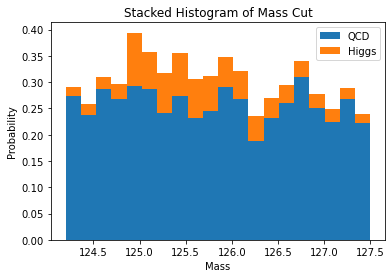

In [10]:
fig, ax = plt.subplots(1, 1)

ax.hist([qcd['mass'], higgs['mass']], bins = 20, density = True, stacked = True, weights = [qcd_weight, higgs_weight], range = (124.2, 127.5))
ax.set_title("Stacked Histogram of Mass Cut")
ax.legend(["QCD", "Higgs"])
ax.set_xlabel("Mass")
ax.set_ylabel("Probability")
plt.show()

Looking at all the significances above, mass had the highest. Using this (with a stacked histogram of the relevant region shown above), we can do multi-feature cuts. These are done by making 2D histograms of each feature with mass, then taking a vertical slice at the mass cut used. A histogram of the other feature is created from this vertical slice, and in this histogram we can determine the significances of the feature. Significances here were just done using the equally sized bin method (method one above) because generally that gave the best results. 

In [11]:
fig, ax = plt.subplots(13,2, figsize = (20,70))
plt.close()
fig2, ax2 = plt.subplots(13, 2, figsize = (20,70))
plt.close()

mass_lower = qcd['mass'].min()
mass_upper = qcd['mass'].max()

bin_size = 10

j = 0
for key in qcd:
    if key != "mass":

        print(key)


        # For cuts
        max_array = []
        for bin_num in range(1, 101, 1):
            lower_val = qcd[key].min()
            upper_val = qcd[key].max()

            hist_qcd = ax[j, 0].hist2d(qcd['mass'], qcd[key], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False)
            hist_higgs = ax[j, 1].hist2d(higgs['mass'], higgs[key], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False)


            qcd_slice = hist_qcd[0][35]
            higgs_slice = hist_higgs[0][35]

            selected_qcd = ax2[j, 0].step(hist_qcd[2][0:bin_num], qcd_slice)
            selected_higgs = ax2[j, 1].step(hist_higgs[2][0:bin_num],higgs_slice)
            ax2[j,0].set_title("QCD " + key)
            ax2[j,1].set_title("Higgs " + key)

            qcd_weight = (20000 / 20100) * (100000 / np.sum(qcd_slice))
            higgs_weight = (100 / 20100) * (100000 / np.sum(higgs_slice))


            cut_sigs = []
            for i in range(bin_num):
                n_qcd = np.sum(qcd_slice[i]) * qcd_weight
                n_higgs = np.sum(higgs_slice[i]) * higgs_weight
                sig = stats.norm.ppf(stats.poisson.cdf(n_higgs + n_qcd, n_qcd, loc = 0))
    #             print(n_qcd, n_higgs, sig)
                if sig != float('inf'):
                    cut_sigs.append(sig)
                elif sig == float('inf'):
                    cut_sigs.append(0)
                
            index_max = cut_sigs.index(max(cut_sigs, key = abs))
            max_array.append([bin_num, cut_sigs[index_max], index_max])
            
        max_sig = max_array[0][1]
        ind = 0
        for k in range(len(max_array)):
            if abs(max_array[k][1]) > abs(max_sig):
                max_sig = max_array[k][1]
                ind = k

        bottom_val = lower_val + max_array[ind][2] * ((upper_val - lower_val) / max_array[ind][0])
        top_val = bottom_val + ((upper_val - lower_val) / max_array[ind][0])
        if max_array[ind][0] == 1:
            print("For " + key + " there is no optimal cut. Expected significance over full range is " + str(max_array[ind][1]) + ".")
        else:    
            print("For " + key + ", the optimal cut is between " + str(bottom_val) + " and " + str(top_val) + " with an expected significance of " + str(max_array[ind][1]) + ".")
        print("[Number of bins, Significance, Bin number] = " + str(max_array[ind]))
        print(" --------------- ")
        
        j = j + 1
        
print(selected_qcd)

pt
For pt, the optimal cut is between 481.1413693536465 and 485.8559870679186 with an expected significance of 1.7333646025125122.
[Number of bins, Significance, Bin number] = [53, 1.7333646025125122, 49]
 --------------- 
eta
For eta there is no optimal cut. Expected significance over full range is 1.577999516320617.
[Number of bins, Significance, Bin number] = [1, 1.577999516320617, 0]
 --------------- 
phi
For phi there is no optimal cut. Expected significance over full range is 1.577999516320617.
[Number of bins, Significance, Bin number] = [1, 1.577999516320617, 0]
 --------------- 
ee2
For ee2, the optimal cut is between 0.1257796674363048 and 0.24916761533128484 with an expected significance of 1.766291324065438.
[Number of bins, Significance, Bin number] = [4, 1.766291324065438, 1]
 --------------- 
ee3
For ee3, the optimal cut is between 6.406593797149574e-07 and 0.00159342473691625 with an expected significance of 3.713225788468455.
[Number of bins, Significance, Bin number] 

Three of these (d2, t2, and t3) give greater than 5 sigma significance, and are thus useful. They will be used in the pseudo-experiment analysis in the Lab 8 file. Below are stacked histograms of the relevant features.

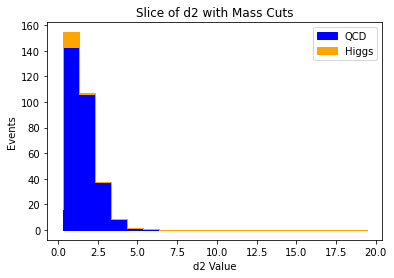

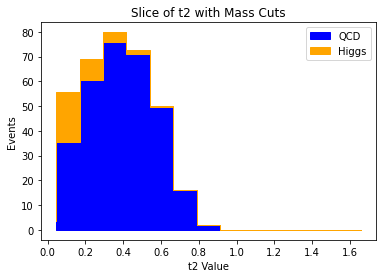

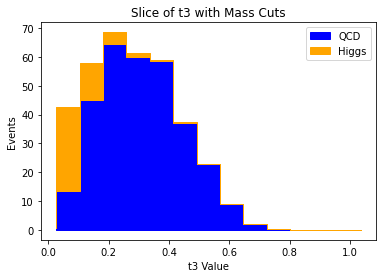

In [14]:
# ------------------ d2 -----------------

fig, ax = plt.subplots(3, 1, figsize = (8,15))
plt.close()
fig2, ax2 = plt.subplots(1, 1)

n_higgs = 100 / 100000
n_qcd = 20000 / 100000

qcd_weight = np.array([n_qcd] * len(qcd['mass']))
higgs_weight = np.array([n_higgs] * len(higgs['mass']))

mass_lower = qcd['mass'].min()
mass_upper = qcd['mass'].max()

lower_val = qcd['d2'].min()
upper_val = qcd['d2'].max()

bin_num = 100

hist_qcd = ax[0].hist2d(qcd['mass'], qcd['d2'], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False, weights = qcd_weight)
hist_higgs = ax[1].hist2d(higgs['mass'], higgs['d2'], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False, weights = higgs_weight)

qcd_slice = hist_qcd[0][35]
higgs_slice = hist_higgs[0][35]

plt.fill_between(hist_qcd[2][0:20], qcd_slice[0:20], color = 'blue', alpha = 1, step = 'pre')
plt.fill_between(hist_higgs[2][0:20], qcd_slice[0:20], qcd_slice[0:20] + higgs_slice[0:20], color = 'orange', alpha = 1, step = 'pre')

ax2.set_title("Slice of d2 with Mass Cuts")
ax2.set_xlabel("d2 Value")
ax2.set_ylabel("Events")
ax2.legend(["QCD", 'Higgs'])

# ------------------ t2 ----------------

fig, ax = plt.subplots(3, 1, figsize = (8,15))
plt.close()
fig2, ax2 = plt.subplots(1, 1)

n_higgs = 100 / 100000
n_qcd = 20000 / 100000

qcd_weight = np.array([n_qcd] * len(qcd['mass']))
higgs_weight = np.array([n_higgs] * len(higgs['mass']))

mass_lower = qcd['mass'].min()
mass_upper = qcd['mass'].max()

lower_val = qcd['t2'].min()
upper_val = qcd['t2'].max()

bin_num = 14

hist_qcd = ax[0].hist2d(qcd['mass'], qcd['t2'], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False, weights = qcd_weight)
hist_higgs = ax[1].hist2d(higgs['mass'], higgs['t2'], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False, weights = higgs_weight)

qcd_slice = hist_qcd[0][35]
higgs_slice = hist_higgs[0][35]

plt.fill_between(hist_qcd[2][0:bin_num], qcd_slice[0:bin_num], color = 'blue', alpha = 1, step = 'pre')
plt.fill_between(hist_higgs[2][0:bin_num], qcd_slice[0:bin_num], qcd_slice[0:bin_num] + higgs_slice[0:bin_num], color = 'orange', alpha = 1, step = 'pre')

ax2.set_title("Slice of t2 with Mass Cuts")
ax2.set_xlabel("t2 Value")
ax2.set_ylabel("Events")
ax2.legend(["QCD", 'Higgs'])

# ------------------- t3 -----------------

fig, ax = plt.subplots(3, 1, figsize = (8,15))
plt.close()
fig2, ax2 = plt.subplots(1, 1)

n_higgs = 100 / 100000
n_qcd = 20000 / 100000

qcd_weight = np.array([n_qcd] * len(qcd['mass']))
higgs_weight = np.array([n_higgs] * len(higgs['mass']))

mass_lower = qcd['mass'].min()
mass_upper = qcd['mass'].max()

lower_val = qcd['t3'].min()
upper_val = qcd['t3'].max()

bin_num = 14

hist_qcd = ax[0].hist2d(qcd['mass'], qcd['t3'], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False, weights = qcd_weight)
hist_higgs = ax[1].hist2d(higgs['mass'], higgs['t3'], bins = [95, bin_num], range = [[mass_lower, mass_upper], [lower_val, upper_val]], density = False, weights = higgs_weight)

qcd_slice = hist_qcd[0][35]
higgs_slice = hist_higgs[0][35]

plt.fill_between(hist_qcd[2][0:bin_num], qcd_slice[0:bin_num], color = 'blue', alpha = 1, step = 'pre')
plt.fill_between(hist_higgs[2][0:bin_num], qcd_slice[0:bin_num], qcd_slice[0:bin_num] + higgs_slice[0:bin_num], color = 'orange', alpha = 1, step = 'pre')

ax2.set_title("Slice of t3 with Mass Cuts")
ax2.set_xlabel("t3 Value")
ax2.set_ylabel("Events")
ax2.legend(["QCD", 'Higgs'])

Overall my significances seem to be lower than my partner's, which makes sense because the ratio of $ N_{Higgs} / N_{QCD} $ is lower for my datasets.